In [94]:
######## Pravljenje baze otkucaja filtriranih signala ########

# Određivanje maksimalne dužine otkucaja

################################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from scipy.signal import butter, sosfiltfilt, filtfilt, iirnotch, hilbert

import ecg_ppg_preprocessing
import csv


###### Read PPG signals ######

def read_ppg_data(root, filename, channel=3):

    filepath = os.path.join(root, filename)
    ppg_data = pd.read_csv(filepath)

    if channel==1:
        ppg_signal = ppg_data['P1g'].to_numpy()
    elif channel==2:
        ppg_signal = ppg_data['P1r'].to_numpy()
    elif channel==3:
        ppg_signal = ppg_data['P2g'].to_numpy()
    else:
        ppg_signal = ppg_data['P2r'].to_numpy()

    t_ppg = ppg_data['Tm'].to_numpy()

    ecg_data = pd.read_csv(os.path.join(root, filename[:-7]+'acc.csv'))
    t_ecg = ecg_data.iloc[:,0].to_numpy()
    ecg_signal = ecg_data.iloc[:,6].to_numpy()

    t_ppg = t_ppg[::5]
    ppg_signal = ppg_signal[::5]
    return t_ppg, ppg_signal, t_ecg, ecg_signal

##### Read data information from .csv files #####

def read_data(root, filename, subjects):

    with open(root + filename, "r", newline="") as csvfile:

        reader = csv.reader(csvfile)
        data = []

        for row in reader:
            converted_row = [float(value) if value else None for value in row[1:]]  # Convert to float
            if row[0] in subjects:
                    data.append(converted_row)

    return data

In [100]:
### Data processing ####
from scipy.interpolate import interp1d
from scipy.signal import resample
import scipy as sp

sos = sp.signal.butter(6, np.array([0.5, 25]), 'bandpass', fs=500, output='sos')

def resample_beat(beat, original_fs=100, target_fs=50):
    duration = len(beat) / original_fs
    target_length = int(duration * target_fs)
    return resample(beat, target_length)

def resample_beat_to_fixed_length(beat, target_length=44):
    return resample(beat, target_length)

root = 'C:/Users/masat/Desktop/Master rad/Klinika/Klinika csv'
root_out = 'C:/Users/masat/Desktop/ETRAN_2025'

info = pd.read_csv(root_out + '/Datasets/information.csv') # Information about inverted signals and prefered channels
subjects = info.iloc[:,0].tolist()
inverted = info.to_numpy()[:,1]
channels = info.to_numpy()[:,2]
classes = info.to_numpy()[:,3]
filenames = [name + "_ppg.csv" for name in subjects] # Files with PPG signals that were estimated to be of decent quality

# Indices of R-peaks that represent interval limits for each PPG beat

ecg_data = read_data(root_out, '/ECG_parameters/r_peaks.csv', subjects)
beats = []
names = []
classif = []
target_length = 251

for i in range(len(filenames)):

    t_ppg, ppg_signal, t_ecg, ecg_signal = read_ppg_data(root, filenames[i], channels[i])
    if(inverted[i]==1):
        ppg_signal = -ppg_signal

    ppg_signal = ecg_ppg_preprocessing.filter_ppg(ppg_signal, 100)
    ppg_signal = resample_beat(ppg_signal, original_fs=100, target_fs=300)
    t_ppg = resample_beat(t_ppg, 100, 300)
    #ecg_signal = ecg_ppg_preprocessing.filter_ecg(ecg_signal, 500)
    ecg_signal = sp.signal.sosfilt(sos, ecg_signal)
    ecg_signal = resample_beat(ecg_signal, original_fs=500, target_fs=300)
    t_ecg = resample_beat(t_ecg, 500, 300)
    r_peak_indices = ecg_ppg_preprocessing.ppg_indices_of_r_peak_times(t_ecg, ecg_data[i])
    t, x = ecg_ppg_preprocessing.split_ppg_to_beats(t_ecg, ecg_signal, ecg_data[i])
    
    # Ovim dobijamo interpolirane otkucaje za svaki snimak
    for j in range(0, len(x)):
        t[j] = t[j] - t[j][0]
        tp = (t[j] - t[j][0]) / (t[j][-1] - t[j][0])

        t_axis_ = np.linspace(0, 1, num=target_length)
        x[j] = (x[j] - x[j].mean()) / x[j].std()
        x_interp = np.interp(t_axis_, tp, x[j])

        beats.append(x_interp)
        names.append(filenames[i][:12])
        classif.append(classes[i])

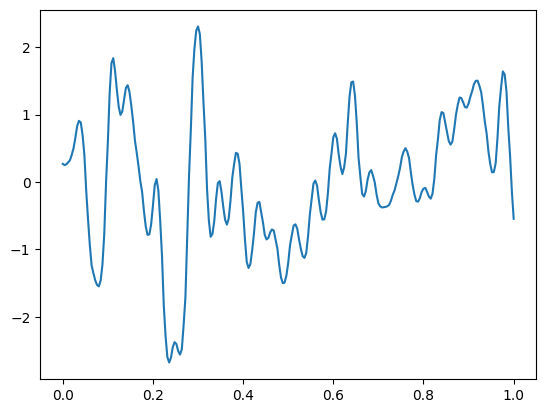

In [106]:
plt.figure()
plt.plot(t_axis_, beats[1000])

In [104]:
df = pd.DataFrame(beats)
df[target_length] = names
df[target_length + 1] = classif
df.to_csv('acc_beats_for_classification_fixed_length_300_hz.csv', index=False, header=False)